In [1]:
# make an image caption generator using computer vision and NLP
# we will be building our model using CNN and LSTM unit

# Import libraries

In [2]:
import numpy as np   
import pandas as pd   
from tqdm import tqdm
import os 
import tensorflow as tf
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img , img_to_array
import pickle # storing numpy features
from tensorflow.keras.layers import add


from keras.preprocessing.sequence import pad_sequences 
from keras.preprocessing.text import Tokenizer 
from keras.models import Model 
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation 
from keras.layers import concatenate, BatchNormalization, Input
# from keras.layers.merge import add 
from keras.utils import to_categorical, plot_model 
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
import matplotlib.pyplot as plt  
import cv2 
import nltk
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Dataset overview
* The dataset consist of images folder which condain all the 8091 images. The 'captions.txt' is a text file consisting of the 4 captions for each image in a format 'image_name,caption'

In [3]:
# whats inside caption.txt?
captions_path='/kaggle/input/flickr8k/captions.txt'
text_caption = open(captions_path, 'r', encoding = 'utf-8').read()
text_caption[:200]

'image,caption\n1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.j'

In [4]:
# each line in caption.txt
text_caption.split('\n')[0:10]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .']

Our model consist of 2 inputs
* Input1= feature vector of the image 
* Input2= input sequence
* Output= output sequence
>To get input1 we will be using a pretrained model such as inceptionv3 model and create a dict named features to map image id to the corresponding feature vectors extracted.

# Things we need to do
1. make a dict named description.
1. clean the captions in the description
1. create list named allcaptions
1. find largest caption
1. tokenize all the words
1. extract features from image using inceptionv3 model
1. pickle extracted feature
1. train test split
1. build model
1. create data generator for the model
>NOTE:will explain what each steps means along the way

# Make a dict named description
>To map each images to the corresponding captions we can make a dictionary named description that as image name as key and list of its 5 captions

In [5]:
def make_description(text):
    description=dict()
    # convert text to a list condaing each line. fist element in the list is 'image,caption' so remove that.
    text_list=text_caption.split('\n')[1:]
    for lines in tqdm(text_list):
        if len(lines)>2: # lines contain space at the end
            image_name=lines.split('.jpg,')[0]
            caption=lines.split('.jpg,')[1]
            if image_name not in list(description.keys()): # check image name already in the dict
                description[image_name]=list()
                description[image_name].append(caption)
            else: 
                description[image_name].append(caption) # append caption to the corresponding image(key) 
    return description
description=make_description(text_caption)
description['1000268201_693b08cb0e']

100%|██████████| 40456/40456 [00:06<00:00, 5934.53it/s] 


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Clean captions in the description
>cleaning of captions include-
>* removing punctuation
>* removing letters
>* making captions lower case
>* remove anything other than alphabetic
>* stemming of words.
>* adding 'startseq ' at the begining to indicate start of a caption
>* adding ' endseq' at the end to indicate end of a caption

In [6]:
# clean describtion
def clean_description(descriptions):
    stemmer = nltk.PorterStemmer()
    for key,caption_list in tqdm(descriptions.items()):
        for i in range(len(caption_list)):
            caption=caption_list[i]
            caption=[ch for ch in caption if ch not in string.punctuation]
            caption=''.join(caption)
            caption = caption.split() 
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = [stemmer.stem(word) for word in caption]
            caption = 'startseq '+" ".join(caption)+' endseq'
            caption_list[i] = caption
        descriptions[key]=caption_list
    return descriptions
cleaned_description=clean_description(description)
cleaned_description['1000268201_693b08cb0e']

100%|██████████| 8091/8091 [00:08<00:00, 918.13it/s]


['startseq child in pink dress is climb up set of stair in an entri way endseq',
 'startseq girl go into wooden build endseq',
 'startseq littl girl climb into wooden playhous endseq',
 'startseq littl girl climb the stair to her playhous endseq',
 'startseq littl girl in pink dress go into wooden cabin endseq']

# Create list named allcaptions

In [7]:
all_captions = []
for key,caption_list in tqdm(cleaned_description.items()):
    for caption in caption_list:
        all_captions.append(caption)
print('total number of captions=',len(all_captions))
all_captions[:10]

100%|██████████| 8091/8091 [00:00<00:00, 787198.18it/s]

total number of captions= 40455


['startseq child in pink dress is climb up set of stair in an entri way endseq',
 'startseq girl go into wooden build endseq',
 'startseq littl girl climb into wooden playhous endseq',
 'startseq littl girl climb the stair to her playhous endseq',
 'startseq littl girl in pink dress go into wooden cabin endseq',
 'startseq black dog and spot dog are fight endseq',
 'startseq black dog and tricolor dog play with each other on the road endseq',
 'startseq black dog and white dog with brown spot are stare at each other in the street endseq',
 'startseq two dog of differ breed look at each other on the road endseq',
 'startseq two dog on pavement move toward each other endseq']

# Find largest caption
>why we need to find the largest caption?
we are trynig to take a word or sequence of words to predict the next word so inorder to make the input and output a uniform length we can pad the input and output to the max length it can be.

In [9]:
# Finding the maximum length of the captions, used for reference for the padding sequence
caption_length_list = [len(caption.split()) for caption in all_captions] # caption_length_list condain length of all the captions
max_index = caption_length_list.index(max(caption_length_list))
max_length = len(all_captions[8049].split()) # you can directly take the max_length from caption_length_list
len(caption_length_list),max_index,max_length 

(40455, 8049, 34)

>so the largest captions contain 34 words

# Tokenize all words
>why tokenize all words?
A distinct number is assigned to each word.

In [10]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f'vocab_size={vocab_size}')
print(f"count of startseq={tokenizer.word_counts['startseq']}")
tokenizer.word_index['startseq']

vocab_size=6048
count of startseq=40455


1

In [11]:
tokenizer.texts_to_sequences(['startseq child in pink dress is climb up set of stair in an entri way endseq'])[0]

[1, 45, 3, 92, 72, 7, 82, 55, 254, 11, 359, 3, 31, 3702, 616, 2]

# Extract features from image using inceptionv3 model
>we will be using a pretrained inceptionv3 model to extract features from the image.

In [12]:
# load inseption v3 model
base_model = InceptionV3(weights = 'imagenet') 
model = Model(base_model.input, base_model.layers[-2].output) 
print(model.summary())

96112376/96112376 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [14]:
# extract features from image
features = {}
directory='/kaggle/input/flickr8k/Images'
user_input = 'run'
if user_input =='run':
    for img_name in tqdm(os.listdir(directory)):
        # load the image from file
        img_path = directory + '/' + img_name
        image = load_img(img_path, target_size=(299, 299))
        # convert image pixels to numpy array
        image = img_to_array(image)
        image = np.expand_dims(image, axis = 0)
        # image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for inception
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature

100%|██████████| 8091/8091 [24:49<00:00,  5.43it/s]


In [25]:
image.shape

(1, 299, 299, 3)

# Pickle features extracted

In [16]:
if user_input =='run':
    # store features in pickle so that we dont want to waste any more time extracting features each time we run the notebook.
    pickle.dump(features, open(os.path.join('/kaggle/working', 'features.pkl'), 'wb'))
else:
    # load features from pickle
    with open(os.path.join('/kaggle/working', 'features.pkl'), 'rb') as f:
        features = pickle.load(f)

In [17]:
# this is our Input1
# features

{'3226254560_2f8ac147ea': array([[0.23555568, 0.28298855, 0.4257177 , ..., 0.469478  , 0.28000134,
         0.28393918]], dtype=float32),
 '214543992_ce6c0d9f9b': array([[0.63332593, 0.20056604, 0.4448882 , ..., 0.1437674 , 0.9883692 ,
         0.21706785]], dtype=float32),
 '2366643786_9c9a830db8': array([[0.5149604 , 0.09205889, 0.98157513, ..., 0.185204  , 0.70270896,
         0.24707104]], dtype=float32),
 '3368819708_0bfa0808f8': array([[0.21177773, 0.14312969, 0.2345734 , ..., 0.92804706, 0.23571202,
         0.3648151 ]], dtype=float32),
 '2190227737_6e0bde2623': array([[0.22736666, 0.5606273 , 0.24622983, ..., 0.12553617, 0.51900417,
         0.17167723]], dtype=float32),
 '2752809449_632cd991b3': array([[0.3081804 , 0.53958046, 0.40372428, ..., 0.47448283, 1.1557082 ,
         0.27117777]], dtype=float32),
 '3097776588_312932e438': array([[0.2045097 , 0.53291726, 0.07774407, ..., 0.36679858, 0.        ,
         0.14137691]], dtype=float32),
 '1206506157_c7956accd5': array([[0

# Train test split

In [18]:
image_ids = list(cleaned_description.keys()) # image_ids contain list of all image id
train, test = train_test_split(image_ids, test_size=0.2, random_state=42)

In [24]:
len(features)

8091

# Build model

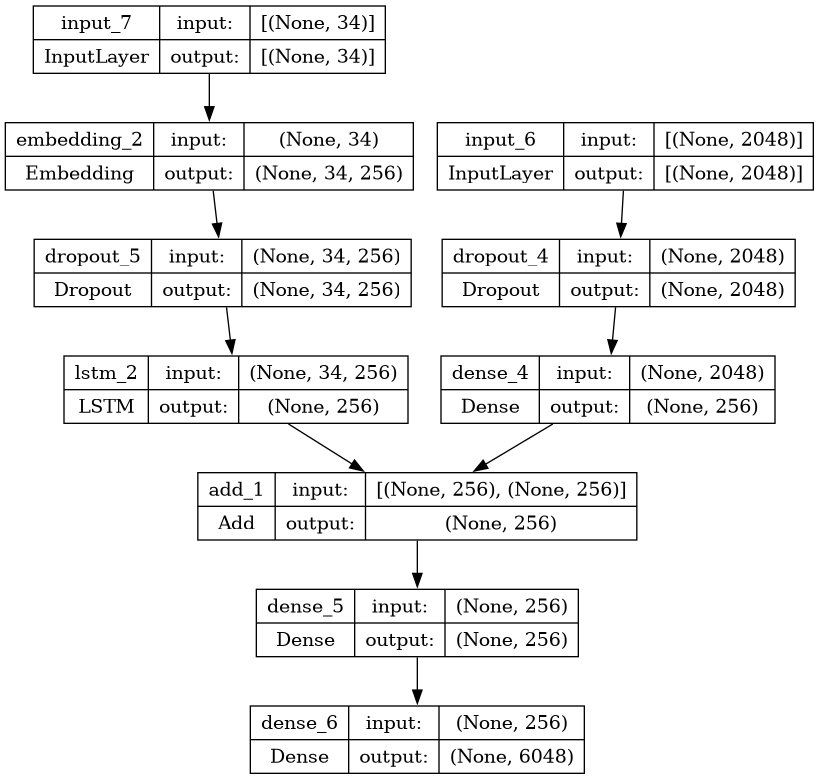

In [28]:
# encoder model
# image feature layers

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

* shape=(4096,) - output length of the features from the inceptionv3 model

* Dense - single dimension linear layer array

* Dropout() - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

* model.compile() - compilation of the model

* loss=’sparse_categorical_crossentropy’ - loss function for category outputs

* optimizer=’adam’ - automatically adjust the learning rate for the model over the no. of epochs

* Model plot shows the concatenation of the inputs and outputs into a single layer

* Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Data generator for the model

In [29]:
# create data generator to get data in batch (avoids session crash)
def data_generator(train, cleaned_description, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in train:
            n += 1
            caption_list = cleaned_description[key]
            # process each caption
            for caption in caption_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
    

In [30]:
# train the model
# train: is a list containing all the image id used for training
# cleaned_description: is a dict mapping image id to its corresponding image captions.
# tokenizer: unique words are assigned with unique numbers.
# max_length: max number of words in a caption
# vocab_size: coun of number of unique words in all the caption

epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs): 
    # create data generator
    generator = data_generator(train, cleaned_description, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 87/202 [===========>..................] - ETA: 3:26 - loss: 2.4365

KeyboardInterrupt: 

In [31]:
# save the model
model.save('/kaggle/working'+'/best_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
# generating caption from image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [35]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = cleaned_description[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 1619/1619 [16:18<00:00,  1.65it/s]


BLEU-1: 0.597961
BLEU-2: 0.370717


---------------------Actual---------------------
startseq black dog and spot dog are fight endseq
startseq black dog and tricolor dog play with each other on the road endseq
startseq black dog and white dog with brown spot are stare at each other in the street endseq
startseq two dog of differ breed look at each other on the road endseq
startseq two dog on pavement move toward each other endseq
--------------------Predicted--------------------
startseq black and white dog is jump over red and white toy endseq


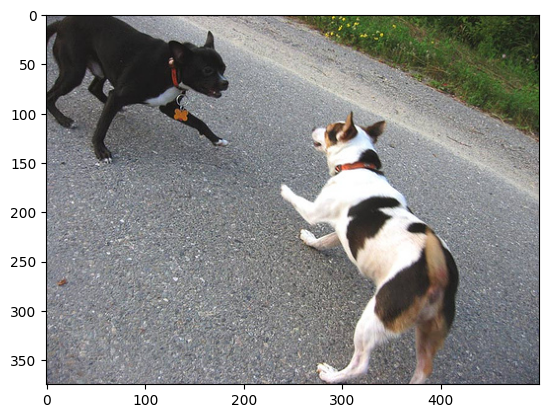

In [38]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/kaggle/input/flickr8k', "Images", image_name)
    image = Image.open(img_path)
    captions = cleaned_description[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
generate_caption("1001773457_577c3a7d70.jpg")